In [1]:
import pandas as pd
import random

from functools import partial
import math
import os
import tqdm
import numpy as np
#import bamboolib as bam
import sklearn
from matplotlib import pyplot 
import seaborn as sns
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
    
from kneed import KneeLocator
import scipy
    

In [2]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from ipysigma import Sigma
import community as community_louvain
import matplotlib.cm as cm
import igraph as ig
from tqdm.notebook import tqdm, trange
import time
import glob

In [3]:
import os
current_directory = os.getcwd()
print("Current directory : ", current_directory)

aymeric =  "/home/aymeric/python-scripts/espadon/data/" #aymeric
jp = '~/Dropbox/Mac/Desktop/CRD Anses/all3/' # Jean Philippe
jp_index = '~/Dropbox/Mac/Desktop/CRD Anses/code/indexation_results/' # Jean Philippe index

if 'aymeric' in current_directory:
    path_base = aymeric

elif 'Mac' in current_directory:
    path_base = jp
elif 'd:/Projects' in current_directory:
    path_base = "d:/Projects/Medialab/"

print("Path base : ", path_base)

Current directory :  /home/aymeric/python-scripts/espadon/my-espadon-notebook
Path base :  /home/aymeric/python-scripts/espadon/data/


In [4]:
corpus_tag= pd.read_csv(f"{path_base}hashtag_by_id.csv", sep = ",", dtype = {"id": str})

In [5]:
corpus_tag["origin"]= "twitter"

## Fréquence des termes par documents (sur facebook)

In [6]:
def term_doc_freq(data, name_period, origin, period, what, targeted_terms, N):
    
    if period == None:
        df_p = data.loc[(data["origin"].isin(origin))]
    else:
        df_p = data.loc[(data["origin"].isin(origin)) & (data[name_period]== period)]
    
    if len(targeted_terms) > 0:
        doc_with_targeted_terms = df_p.loc[df_p["term"].isin(targeted_terms)]
        df_p = df_p.merge(doc_with_targeted_terms[["id"]], on = ["id"], how = "inner")
    else:
        pass
        
    if N != None:
        topN=df_p["hashtag"].value_counts().index[:N]

        #topN = df_p["term"].value_counts().index[:N]
        df_p=df_p.loc[(df_p["hashtag"].isin(topN))]
    else:
        pass

    df_term_freq = df_p.groupby(['hashtag', what]).agg(freq=('origin', 'size')).reset_index()
    return df_term_freq

## Création de la matrice termes-termes
multiplication de la matrice documents-termes par sa transposée

In [7]:
def create_term_term_matrix(data, what):
    table = pd.pivot_table(data, 
                           values='freq', index=[what],columns=["hashtag"], aggfunc=np.sum, fill_value=0, observed = True)
    
    term_term = np.dot(table.T, table) # multiplication de la transposé de
    return term_term, table

In [8]:
def mutual_information_matrix(matrix): # a term_term matrix
    mi_matrix = []
    #freq_term = [x for x in matrix.diagonal()] # pour obtenir la fréquence de chaque terme (somme de chaque ligne)
    freq_term = np.sum(matrix,axis=1).tolist() - matrix.diagonal()
    
    #Nombre de paires est égale à la somme des lignes moins la diagonale (à diviser par 2?)
    #Nb_pairs = (sum(np.sum(matrix,axis=1).tolist()) -  sum(freq_term))/2 
    Nb_pairs = sum(freq_term)
    for i in range(len(matrix)):
        list_mi = []
        for j in range(len(matrix)):
            nb_cooc = matrix[i,j] #nombre de cooccurrences des termes i et j
            freq_i = freq_term[i] # fréquence de i
            freq_j = freq_term[j] # fréquence de j
        
            if i == j : 
                mutual_info = 0
            else:
                if nb_cooc == 0 :
                    mutual_info = 0
                else: #calcule mutual information
                    num = (nb_cooc*Nb_pairs)
                    denom = freq_i*freq_j
                    mutual_info = np.log(num/denom)
                    if mutual_info < 0:
                        mutual_info = 0

            list_mi.append(mutual_info)
        mi_matrix.append(list_mi)
    return mi_matrix

## Calcule du cosine

In [9]:
def find_k_neighbor(mi_matrix, precompute):
    mi_array = np.array(mi_matrix)
    
    if precompute == True:
        m =scipy.sparse.csc_matrix(mi_array)
        dist=metrics.pairwise.cosine_distances(m)
        list_voisin = []
        list_voisin_dist =[]
        samples = dist
        neigh = NearestNeighbors(n_neighbors=6, metric='precomputed')
        neigh.fit(samples)
        for x in range(len(dist)):
            voisins = neigh.kneighbors(dist[[x]], return_distance=True)
            voisins_dist = voisins[0].tolist()
            voisins_id = voisins[1].tolist()
            #print(voisins_id)
            list_voisin.append(voisins_id[0])
            list_voisin_dist.append(voisins_dist[0])
    else:
        list_voisin = []
        list_voisin_dist =[]
        samples = mi_array
        neigh = NearestNeighbors(n_neighbors=6, metric='cosine')
        neigh.fit(samples)
        for x in range(len(mi_array)):
            voisins = neigh.kneighbors(mi_array[[x]], return_distance=True)
            voisins_dist = voisins[0].tolist()
            voisins_id = voisins[1].tolist()
            #print(voisins_id)
            list_voisin.append(voisins_id[0])
            list_voisin_dist.append(voisins_dist[0])
    return list_voisin, list_voisin_dist
    
    
        

In [10]:
def matrix_to_df(list_voisin, list_voisin_dist, table):
    df_dist = pd.DataFrame(list_voisin_dist)
    df_dist["term"] = table.columns
    df_dist["id"] = df_dist.index
    list_id = []
    list_term = []
    list_voisins_dist =[]
    for x, term in enumerate(df_dist["term"]):
        for col in df_dist.columns[0:-2]:
            list_id.append(x)
            list_term.append(term)
            neig_dist = df_dist[col].iloc[x]
            list_voisins_dist.append(neig_dist)
    data = {"id": list_id, "term": list_term, "distances":list_voisins_dist}
    df_dist_voisin = pd.DataFrame(data)#dtype={"id" :"string"})
    df_dist_voisin["row_id"] = df_dist_voisin.index #.astype('str')
    df_dist_voisin = df_dist_voisin.astype({"id": str, "row_id": str})

    df_voisin = pd.DataFrame(list_voisin)
    df_voisin["term"] = table.columns
    df_voisin["id"] = df_voisin.index
    list_id = []
    list_term = []
    list_voisins =[]
    for x, term in enumerate(df_voisin["term"]):
        for col in df_voisin.columns[0:-2]:
            list_id.append(x)
            list_term.append(term)
            neig = df_voisin[col].iloc[x]
            list_voisins.append(neig)
    data = {"id": list_id, "term": list_term, "voisins":list_voisins}
    df_voisin = pd.DataFrame(data)
    df_voisin["row_id"] = df_voisin.index
    df_voisin = df_voisin.astype({"id": str, "row_id": str, "voisins" : str})
    df_voisin = df_voisin.merge(df_dist_voisin, on=["row_id", "term", "id"], how = "left")
    
    df_id = df_voisin[["id", "term"]].drop_duplicates()
    df_id["voisins"] = df_id["id"].astype('str')
    df_id = df_id.astype({"voisins": str, "id": str})
    df_voisin = df_voisin.merge(df_id, on=["voisins"], how ="left")
    
    df_voisin = df_voisin.drop(columns=["voisins"])
    df_voisin["id_x"] = "id_"+df_voisin["id_x"]
    df_voisin["id_y"] = "id_"+df_voisin["id_y"]
    df_voisin["row_id"] = "row_id_"+df_voisin["row_id"]
    df_voisin = df_voisin.loc[df_voisin["term_x"]!=df_voisin["term_y"]]
    
    return df_voisin

In [11]:
def dessine_moi_un_graph(data, origin, threshold, resolution, save_figure):
    
    df_voisin0 = data[["term_x", "term_y", "distances"]].loc[df_voisin["distances"]>= threshold]
    
    G = nx.from_pandas_edgelist(df_voisin0, 'term_x', 'term_y', ['distances'])
    btw = nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)
    degres = nx.degree_centrality(G)
    partition = community_louvain.best_partition(G, weight = "distances",resolution= resolution)
    
    ## set note attribute : degre, cluster
    nx.set_node_attributes(G, partition, 'louvain')
    nx.set_node_attributes(G, btw, 'betweenness')
    nx.set_node_attributes(G, degres, 'degres')
    
    #map cluster with terms
    df_voisin0["cluster_x"] = df_voisin0["term_x"].map(partition)
    df_voisin0["cluster_y"] = df_voisin0["term_y"].map(partition)
    
    
    
    # remove edges between nodes belonging to different clusters
    df_voisin1 = df_voisin0.loc[(df_voisin0["cluster_x"]== df_voisin0["cluster_y"])] 
    
    
    # create a new graph
    G1 = nx.from_pandas_edgelist(df_voisin1, 'term_x', 'term_y', ['distances', "cluster_x", "cluster_y"])
    btw = nx.betweenness_centrality(G1, k=None, normalized=True, weight=None, endpoints=False, seed=None)
    degres = nx.degree_centrality(G1)
    
    nx.set_node_attributes(G1, partition, 'louvain')
    nx.set_node_attributes(G1, btw, 'betweenness')
    nx.set_node_attributes(G1, degres, 'degres')
    
    # create a dataframe with terms, their cluster and their degrees
    list_term = []
    list_cluster = []
    list_degres = []
    for key, value in partition.items():
        list_term.append(key)
        list_cluster.append(value)
        list_degres.append(degres[key])
    
    df_cluster = pd.DataFrame(data={"terms":list_term, "cluster":list_cluster, "degres": list_degres}).sort_values(by=["cluster", "degres"], ascending = [True, False])
    df_cluster_5 = df_cluster.groupby("cluster").head(5)
    
    dict_5_term = {}
    for c in df_cluster_5["cluster"]:
        list_5_terms = df_cluster_5["terms"].loc[df_cluster_5["cluster"]==c]
        fifth_terms = f'Cluster {c} : {"; ".join(x for x in list_5_terms)}'
        dict_5_term[c]= fifth_terms

    fifth_terms

    df_cluster_freq = df_cluster.groupby(["cluster"]).agg(nb_terms = ("terms", "size")).reset_index().sort_values(by="nb_terms", ascending = False)
    df_cluster_freq["list_5st_terms"] = df_cluster_freq["cluster"].map(dict_5_term)
    
    figure = sns.catplot(data=df_cluster_freq, x="nb_terms", y="list_5st_terms", kind="bar").set(title=f'Les clusters ({origin})')
    
    if save_figure == True:
        figure.savefig(f"{path}/analyse_periods/cluster_{origin}.jpeg")
    else:
        pass
    
    return G, df_cluster, figure, df_cluster_freq, dict_5_term, df_voisin0

In [12]:
df_term_freq = term_doc_freq(data = corpus_tag, origin = ["twitter"], 
                             name_period = "P_facebook", period = None, 
                             what = "id", targeted_terms = [],
                            N = 200)


In [13]:
term_term, table = create_term_term_matrix(data = df_term_freq,  what ="id")

In [14]:
mi_matrix = mutual_information_matrix(matrix= term_term)

In [15]:
list_voisin, list_voisin_dist = find_k_neighbor(mi_matrix = mi_matrix, precompute = "True")

In [16]:
list_voisin, list_voisin_dist = find_k_neighbor(mi_matrix = mi_matrix, precompute = "True")
df_voisin = matrix_to_df(list_voisin, list_voisin_dist, table)

<AxesSubplot:>

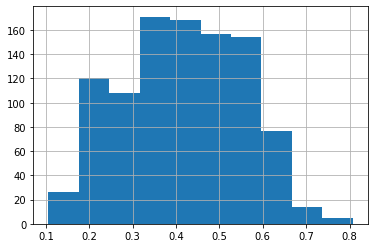

In [17]:
df_voisin.distances.hist()

# Analyse des cooccurence entre hashtags

/home/aymeric/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


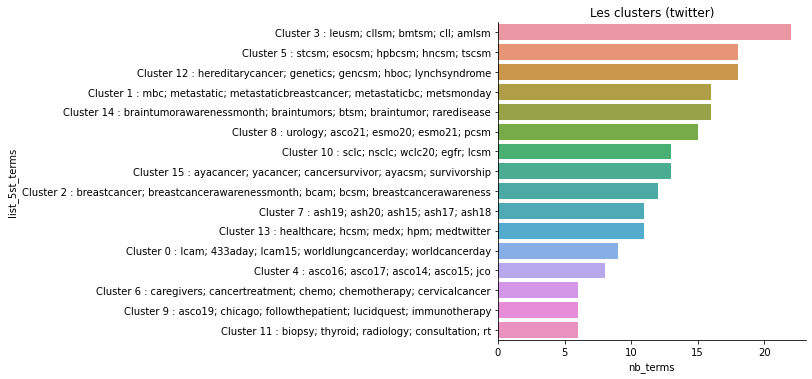

In [18]:
G, df_cluster, figure, df_cluster_freq, dict_5_term, df_voisin0 = dessine_moi_un_graph(data = df_voisin, origin= "twitter", threshold= 0.2, resolution=2, save_figure = False)

## Le graphe des co-occurrence

basé sur les 5 plus proches voisins de chaque noeud

In [19]:
Sigma(G, node_color = "louvain", node_size = "degres")

Sigma(nx.Graph with 200 nodes and 674 edges)

![](images/graph.svg)